# Create Airbnb price suggestion tool for new hosts using machine learning
**Amanda Wahlers**
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
ATTENTION: This is the raw code file I wrote to complete this project while familiarizing myself with the data, so it contains many data visualizations, statistics, and print statements that allowed me to better understand the data. I've included this to demonstrate how I go about understanding the data while working. "Production-ready" versions of the prediction model and exploratory analysis/data visualizations can be found in the companion notebooks in this folder.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Goal: Use machine learning to create a tool that suggests a listing price for new Airbnb hosts based on the prices and characteristics of other listings in their market. 

Task: Supervised ML, regression - Predict listing price using features that would be available to a new host and use these to generate suggested pricing for new listings. 

Dataset: Bozeman, Montana, US; 10 August, 2023; downloaded from Inside Airbnb @ https://insideairbnb.com/get-the-data/

This notebook contains: 
1. Data cleaning: Extracting numeric features from strings, subsetting dataset to target listings (non-institutional host, non-luxury), dealing appropriately with missing values. 
2. Feature engineering: Using my domain knowledge and insights from exploratory analysis to extract important amenities, create sensible listing types (house, apt, guest house, private room), and interact these listing types with key characteristics that predict price.
3. Exploratory Analysis: Visualizing correlations between features, analyzing geographic patterns, and visualizing property characteristics such as number of bedrooms and number of listings per host.
4. Set up pipelines to tune and train regularized regression (Lasso, Ridge, Elastic Net) and tree ensemble (Random Forest, Gradient Boosting Regressor, XGBoost Regressor) algorithms with embedded feature selection.
5. Train models, calculate performance metrics, & choose the best model. 

Results: The best model was able to predict the price with a mean absolute error of $53 and an R^2 suggesting that it captured 70% of the variation in the data.


## Library Imports

In [3]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Goepandas for GIS
import geopandas as gpd

# Matplotlib for visualization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('white')

# Import function to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import functions for standardization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Import function for creation model pipeline
from sklearn.pipeline import make_pipeline

# Import regularized regression algorithms
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# Import tree ensemble algorithms
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Import helper function for cross-validation
from sklearn.model_selection import GridSearchCV

# Import performance metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.exceptions import NotFittedError

import pickle

from math import isinf

## Data Cleaning

Data cleaning first because almost all useful features need to be made numeric before exploratory analysis. 

In [5]:
listings = pd.read_csv('Data/August_2023/listings_detail.csv',index_col='id')

In [6]:
# Drop duplicates
print(listings.shape)
listings = listings.drop_duplicates()
print(listings.shape)

(602, 74)
(602, 74)


In [7]:
# Subset to features that are relevant to the task at hand

# Drop features for which all values are missing
listings.dropna(axis="columns", how="all", inplace=True)

# Keep (first pass on) potentially useful features
listings = listings[['latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 
                     'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'host_is_superhost',
                     'number_of_reviews', 'review_scores_rating', 'instant_bookable', 
                     'minimum_nights', 'minimum_minimum_nights', 'calculated_host_listings_count']]


In [8]:
# Convert objects that should be numeric types

# Bathrooms (string -> float)
listings.bathrooms_text.unique()
listings.bathrooms_text.replace('Half-bath', '0.5 baths', inplace=True)
listings['bathrooms'] = listings['bathrooms_text'].str.split(' ').str[0].astype(float)
listings[['bathrooms', 'bathrooms_text']].head(20)
listings.bathrooms.unique()

# Price (string -> float)
listings['price_str'] = listings['price'].copy()
listings['price'] = listings['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
listings[['price', 'price_str']].head()

# Instant bookable (str -> indicator)
listings['instant_bookable'].unique()
listings['instant_bookable'].isna().sum()
listings['instant_bookable'] = (listings['instant_bookable'] == 't').astype(int)
listings['instant_bookable'].unique()

# Bedrooms (string -> int)
listings['bedrooms'] = listings['bedrooms'].astype('Int64')
listings.groupby('room_type').bedrooms.value_counts() 
listings.bedrooms.fillna(0, inplace=True) # Seems likely that this indicates 0 "bedroooms" (studio, private room, tent, etc)
listings['bedrooms'] = listings['bedrooms'].astype(int)

# Beds (fill in a few missing beds with the # of bedrooms - presumably there is 1 bed(ish thing) in a 1 bedroom space)
listings[listings['beds'].isna()].head()
listings.beds.fillna(listings.bedrooms, inplace=True) 

# Superhost status (string -> indicator)
listings['host_is_superhost'].unique()
listings['host_is_superhost'].isna().sum()
listings['host_is_superhost'] = (listings['host_is_superhost'] == 't').astype(int)
listings['host_is_superhost'].mean()

0.6362126245847176

In [9]:
# Check pricing
listings.price.describe().transpose()
p = listings.price.quantile(0.97)

# Aim tool at non-luxury stays, so drop any listings over p97 (~$1,000 in this market)
listings = listings[listings['price'].between(1, p)]
listings.shape

(582, 19)

## Feature Engineering 
As an Airbnb host and frequent guest, I like to think I have some expertise on Airbnb. Here I engineer two key features that I suspect will provide useful information for predicting listing price: \
\
**Listing type:** House, Apt/condo/townhouse, Guest suite/house, Private room \
This is useful because property type is too detailed for this relatively small market and room type is too general. \
**Key amenities:** Hot tub, wifi, air conditioning, pet-friendliness, kitchen, ...etc.\
**Attributes x listing type:** Attributes should be more predictive of price within a listing type than across \
For example: AC > no AC; but also AC in a house > no AC in a house > AC in  a private room

### 1. Listing type: House, Apt/condo/townhouse, Guest suite/house, Private room

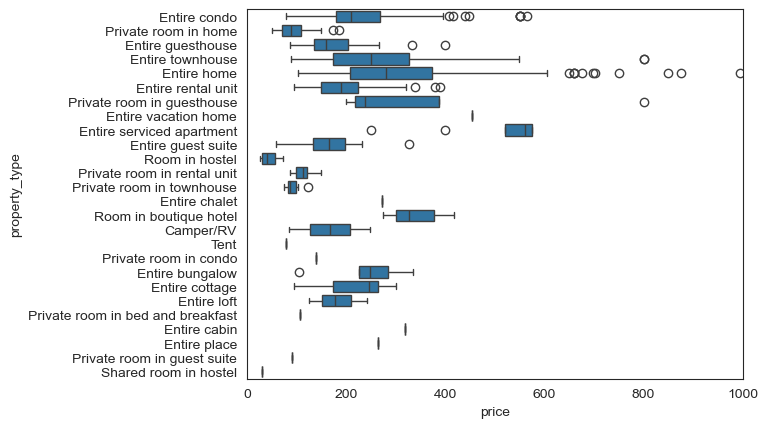

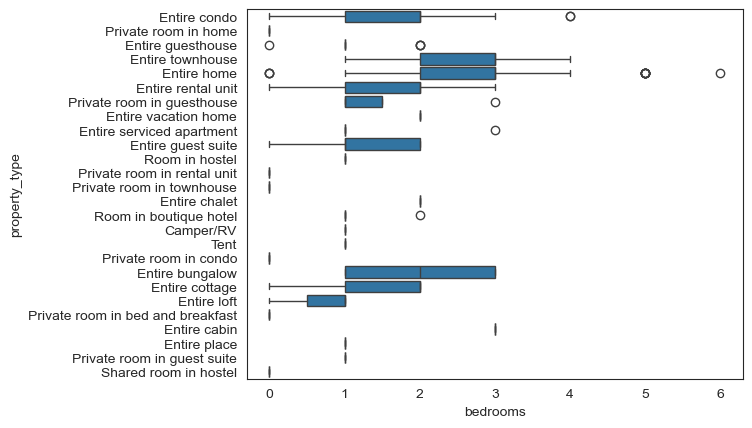

property_type
Entire home                          183
Entire condo                          98
Entire rental unit                    88
Entire townhouse                      63
Entire guesthouse                     37
Entire guest suite                    28
Private room in home                  21
Room in boutique hotel                13
Entire serviced apartment              8
Private room in townhouse              6
Entire cottage                         5
Entire bungalow                        5
Private room in rental unit            5
Room in hostel                         4
Private room in guesthouse             4
Entire loft                            3
Camper/RV                              2
Private room in bed and breakfast      1
Entire place                           1
Entire cabin                           1
Private room in guest suite            1
Entire chalet                          1
Private room in condo                  1
Tent                                   1
En

In [12]:
# Use price to help gauge likely groupings for ambiguous types (e.g. cottage)
listings.groupby('property_type').mean(numeric_only=True)
sns.boxplot(y='property_type', x='price', data=listings)
plt.xlim(0,1000)
plt.show()

# Use # bedrooms to help gauge likely groupings for ambiguous types (e.g. cottage)
listings['bedrooms_str'] = listings['bedrooms'].astype(str)
sns.boxplot(y='property_type', x='bedrooms', data=listings)
plt.show()

# Display counts of each type
listings.property_type.value_counts()

In [13]:
# Drop types of properties that will be outside the scope of the tool or are unable to be predicted in this market
# Hotel rooms & luxury serviced apartments (would likely have institutional hosts), & shared rooms (only 1)
listings = listings[~listings.property_type.isin(['Entire serviced apartment','Room in boutique hotel',
                                               'Room in hostel','Shared room in hostel'])]
listings.shape

(556, 20)

In [14]:
# Assign new listing types based on domain knowledge and shared characteristics in this market
listings['listing_type'] = listings['property_type'].copy()
listings['listing_type'].replace(['Entire home','Entire townhouse', 'Entire bungalow', 'Entire chalet',
                                  'Entire cabin', 'Entire vacation home'], 'house', inplace=True)
listings['listing_type'].replace(['Entire condo', 'Entire rental unit'], 'apt', inplace=True)
listings['listing_type'].replace(['Entire guesthouse', 'Entire guest suite', 'Entire cottage', 'Entire loft', 'Entire place'], 'guest_suite', inplace=True)
listings['listing_type'].replace(['Private room in home', 'Private room in townhouse', 'Private room in rental unit', 
                          'Private room in guesthouse', 'Private room in bed and breakfast', 
                          'Private room in condo', 'Private room in guest suite', 'Camper/RV', 'Tent'], 'private_room', inplace=True)

listing_type
house           254
apt             186
guest_suite      74
private_room     42
Name: count, dtype: int64


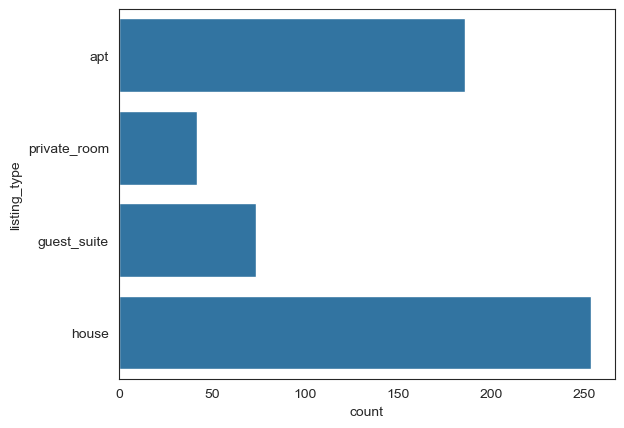

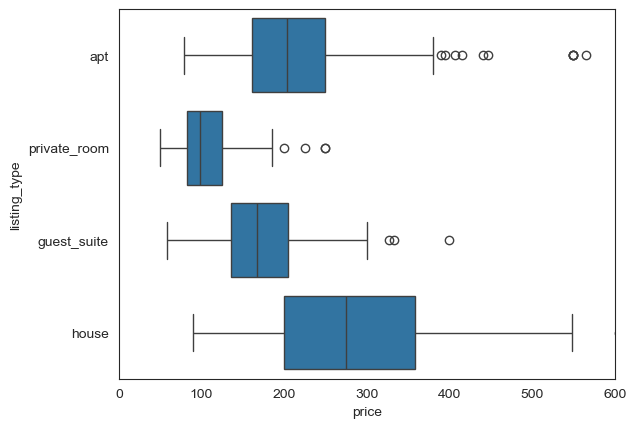

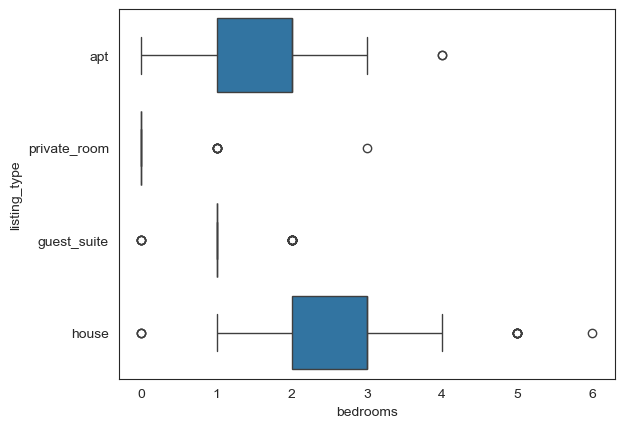

In [15]:
# Assess groupings
print(listings['listing_type'].value_counts())

sns.countplot(listings.listing_type)
plt.show()
    
sns.boxplot(y='listing_type', x='price', data=listings)
plt.xlim(0,600)
plt.show()

sns.boxplot(y='listing_type', x='bedrooms', data=listings)
plt.show()

### 2. Key amenities: Kitchen, hot tub, wifi, air conditioning, pet-friendliness, ...etc.

In [17]:
#pd.set_option('display.max_colwidth',None)
#listings['amenities'].head(100)

In [18]:
# Create indicators for amenities that may correlate with price
listings['amenities'] = listings.amenities.str.lower()

# Loop through rest of amenities, creating indicator variables for important amenities
amenities_list = ['wifi', 'hot tub', '\"kitchen\"', 'tv', 'coffee', '\"washer\"|\"free washer', '\"dryer\"|free dryer', 
                  'backyard', '\"pets allowed\"', 'workspace', 'pool', 'fire pit', 'bbq', 
                  'window ac|air conditioning|ac - split', 'free parking', 'dishwasher', 'gym', 'self check-in', 'stove', 'view',
                 'patio', 'crib'] 
for amenity in amenities_list:
    listings[amenity] = listings['amenities'].str.contains(amenity).astype(int)


listings[amenities_list].mean()

wifi                                    0.991
hot tub                                 0.047
"kitchen"                               0.953
tv                                      0.939
coffee                                  0.903
"washer"|"free washer                   0.874
"dryer"|free dryer                      0.822
backyard                                0.437
"pets allowed"                          0.255
workspace                               0.662
pool                                    0.029
fire pit                                0.153
bbq                                     0.424
window ac|air conditioning|ac - split   0.671
free parking                            0.802
dishwasher                              0.680
gym                                     0.032
self check-in                           0.799
stove                                   0.734
view                                    0.392
patio                                   0.642
crib                              

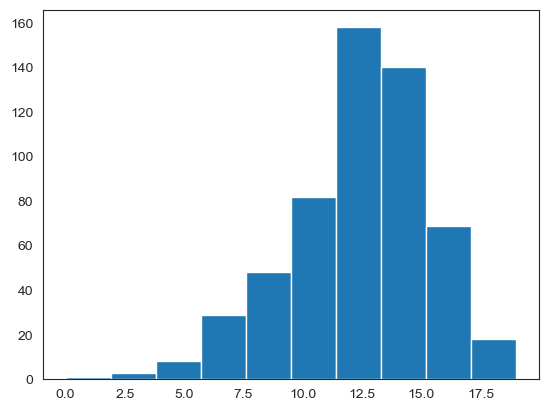

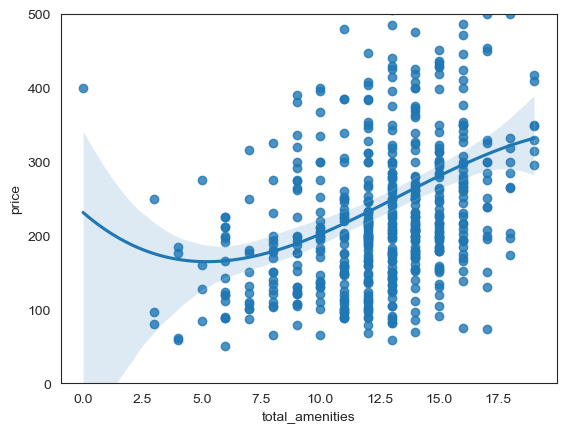

In [19]:
# Add up total number of amenities for each property (of course, amenities are probably not created equal)
listings['total_amenities'] = listings[amenities_list].sum(axis=1)

# Show distribution
plt.hist(listings['total_amenities'])
plt.show()

# Plot against price
sns.regplot(x='total_amenities', y='price', data=listings, order=3)
plt.ylim(0,500)
plt.show()

In [20]:
# Rename where applicable
listings = listings.rename(columns={'\"kitchen\"': 'kitchen', '\"washer\"|\"free washer': 'washer', '\"dryer\"|free dryer': 'dryer',
                         '\"pets allowed\"': 'pets allowed', 'window ac|air conditioning|ac - split': 'ac'}, errors='raise')


### 3. Other feature engineering
Ensure there aren't any sparse classes & aggregate/censor where appropriate.

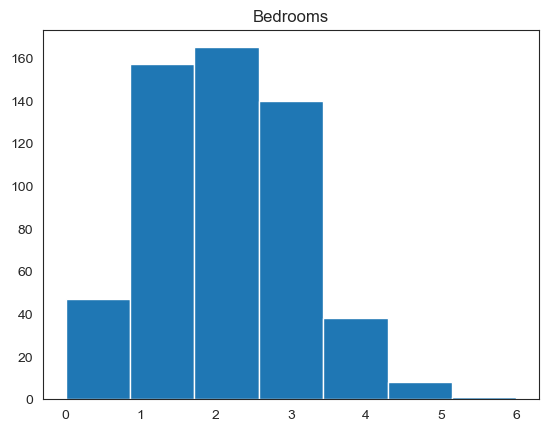

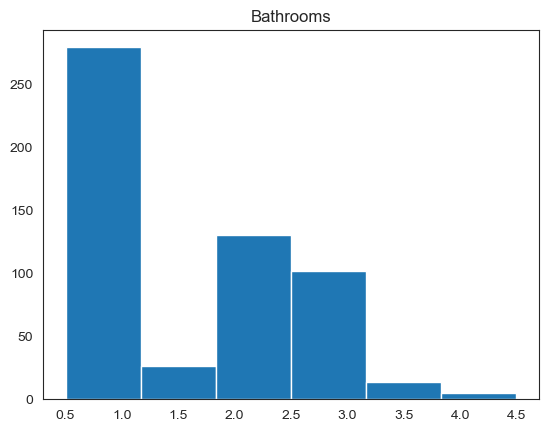

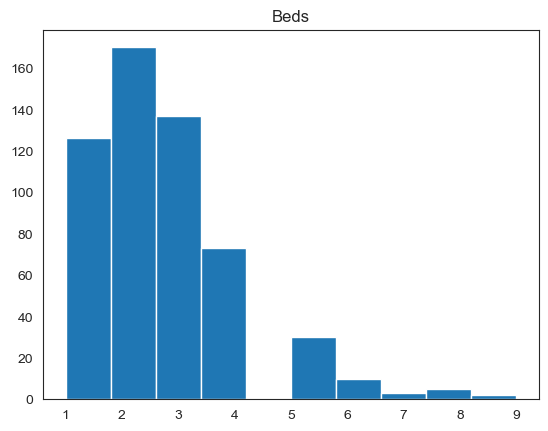

In [22]:
# Check for sparseness or outliers in remaining features

plt.title('Bedrooms')
plt.hist(listings.bedrooms, bins=7)
plt.show()

plt.title('Bathrooms')
plt.hist(listings.bathrooms, bins=6)
plt.show()

plt.title('Beds')
plt.hist(listings.beds, bins=10)
plt.show()

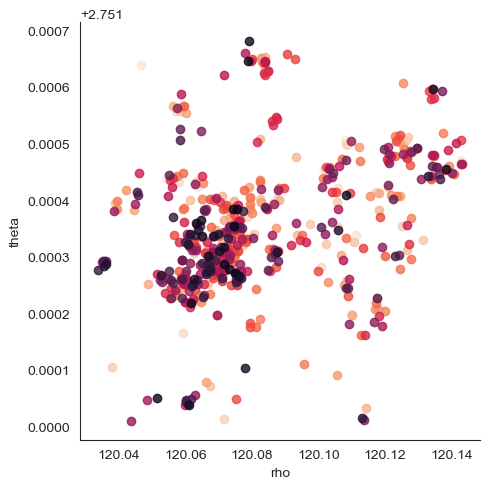

In [23]:
# Generate polar coordinates from lat, long

# Define function that takes in long+lat and produces polar coordinates
def polarcoords(long, lat):
    z = long + lat * 1j
    rho, theta = np.abs(z), np.angle(z)

    return rho, theta

# Call function and store polar coordinates
listings['rho'],listings['theta'] = polarcoords(listings.longitude, listings.latitude)

# Listings grouped near the city center seem to be more expensive
sns.lmplot(x='rho', y='theta', hue='price', palette='rocket_r', data=listings, scatter=True, legend=False, fit_reg=False)
plt.xlabel('rho')
plt.ylabel('theta')
plt.show()

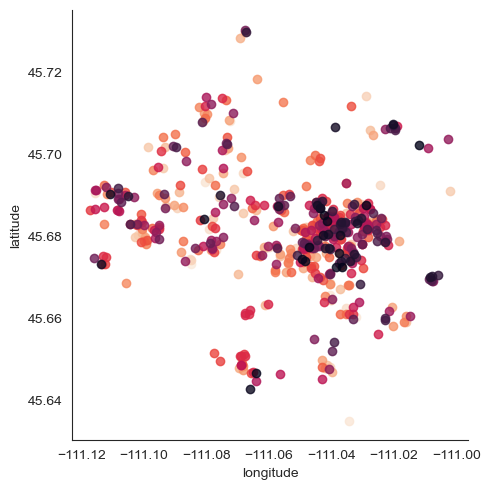

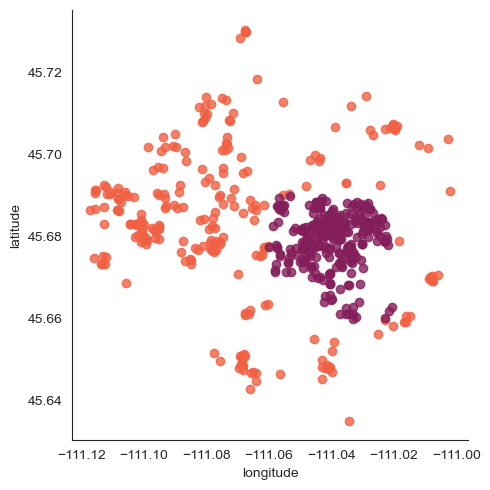

In [24]:
# Generate indicator that listing is located downtown
sns.lmplot(x='longitude', y='latitude', hue='price', palette='rocket_r', data=listings, scatter=True, legend=False, fit_reg=False)

listings['downtown'] = (listings.longitude.between(-111.06,-111.02) & listings.latitude.between(45.66, 45.69)).astype(int)
sns.lmplot(x='longitude', y='latitude', hue='downtown', palette='rocket_r', data=listings, scatter=True, legend=False, fit_reg=False)

In [25]:
# Create indicator that property only accepts long stays (28+ days) 
listings.minimum_minimum_nights.value_counts()
listings['long_stays_only'] = (listings.minimum_minimum_nights >=28).astype(int)
listings.groupby('listing_type').long_stays_only.mean()
listings.long_stays_only.value_counts()

long_stays_only
0    473
1     83
Name: count, dtype: int64

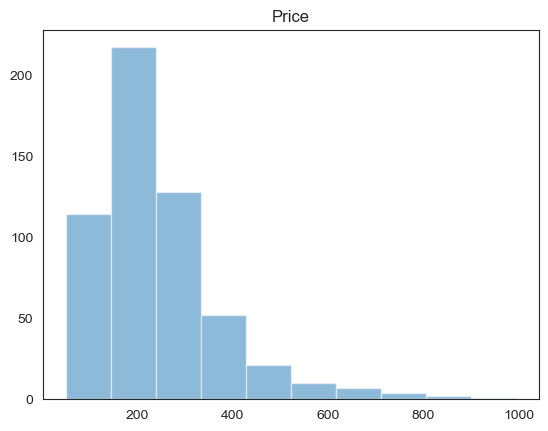

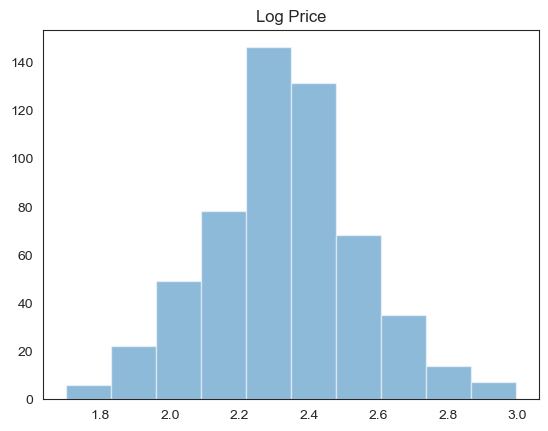

In [26]:
# Generate log price since price is right tailed
listings['log_price'] = np.log10(listings.price)

plt.hist(listings['price'], bins=10, alpha=0.5)
plt.title('Price')
plt.show()

plt.hist(listings['log_price'], bins=10, alpha=0.5)
plt.title('Log Price')
plt.show()

<Axes: xlabel='max_guests', ylabel='price'>

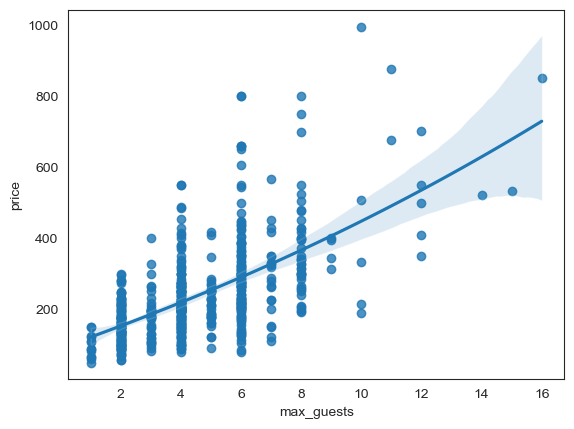

In [27]:
# Max # of guests (helpful for predicting the highest prices)
listings.accommodates.value_counts()
listings['max_guests'] = listings['accommodates'].copy()

listings.max_guests.value_counts()
sns.regplot(x='max_guests', y='price', data=listings, order=3)

In [28]:
listings.bedrooms.unique()

array([2, 0, 1, 3, 4, 5, 6])

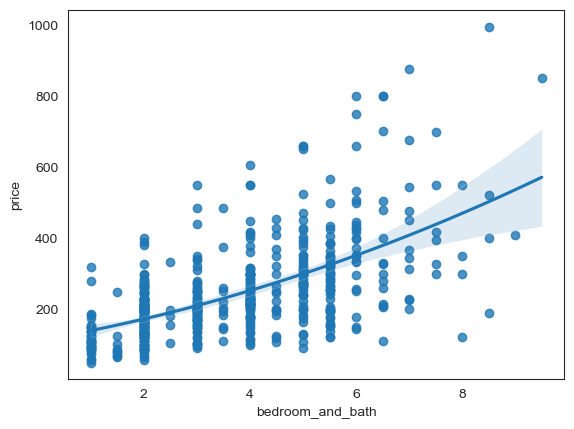

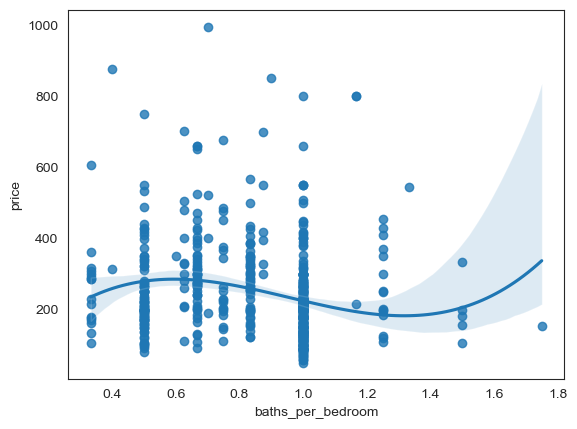

In [29]:
# Bedrooms + bathrooms rooms
listings['bedroom_and_bath'] = listings['bedrooms'] + listings['bathrooms']
sns.regplot(x='bedroom_and_bath', y='price', data=listings, order=2)
plt.show()

# Ratio of bedrooms to bathrooms
listings['baths_per_bedroom'] = listings['bathrooms']/listings['bedrooms']
listings.loc[listings.baths_per_bedroom > 10, 'baths_per_bedroom'] = 1.0  # get rid of pesky infinities when there are 0 bedrooms
sns.regplot(x='baths_per_bedroom', y='price', data=listings, order=3)
plt.show()

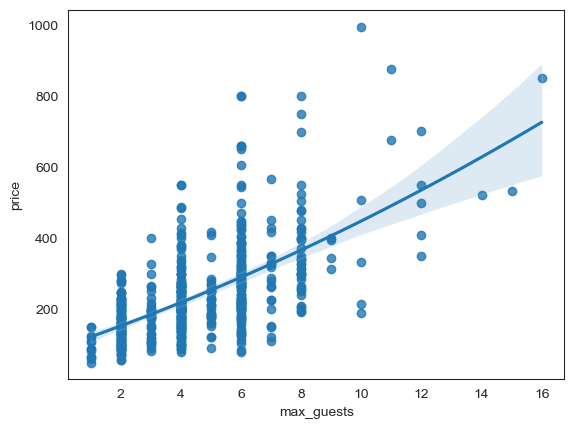

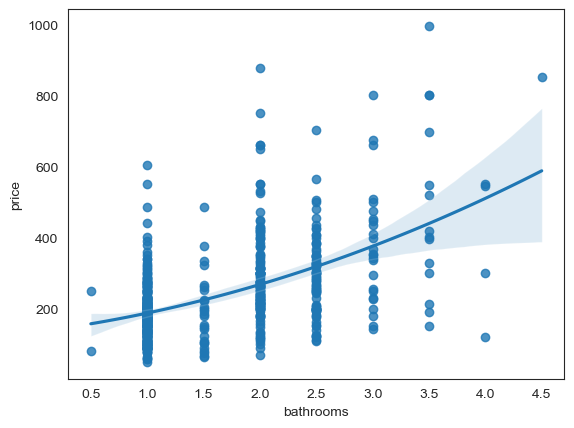

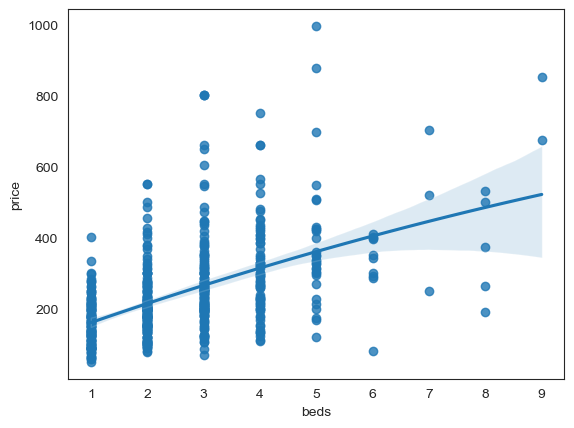

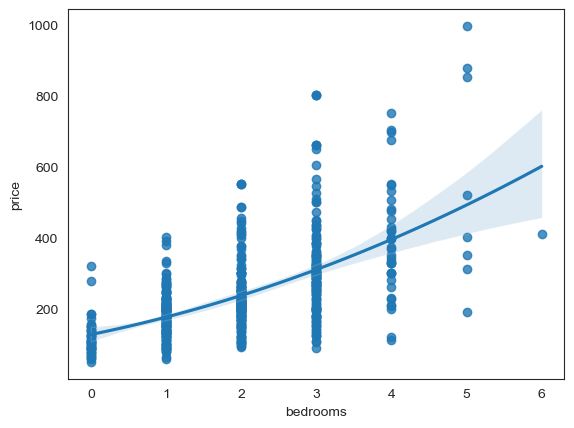

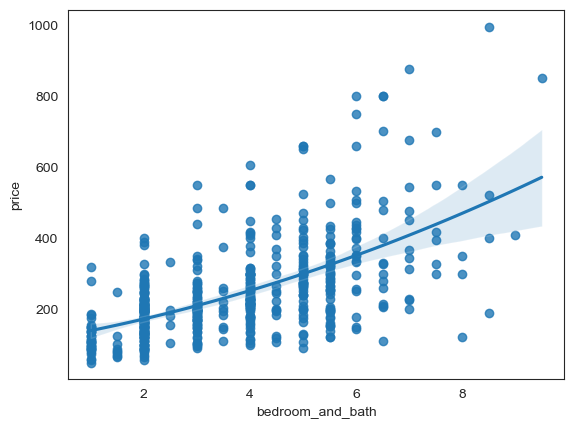

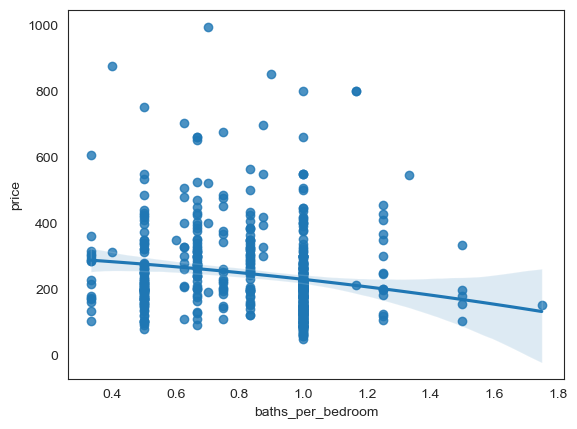

In [30]:
# Create squared & cubed terms for important features to help capture non-linear effects 
features = ['max_guests', 'bathrooms', 'beds', 'bedrooms', 'bedroom_and_bath', 'baths_per_bedroom']

for f in features:
    listings['{}_sq'.format(f)] = listings[f] * listings[f]
    listings['{}_cu'.format(f)] = listings[f] * listings[f] * listings[f]
    sns.regplot(x=f, y='price', data=listings, order=2)
    plt.show()

0.34172661870503596

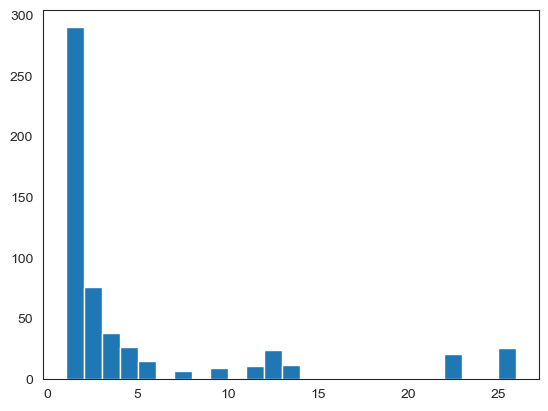

In [31]:
# Look at hosts with single listings versus multiple
plt.hist(listings.calculated_host_listings_count, bins=25)
listings.calculated_host_listings_count.describe()

# Create indicator for 3+ listings ('job' rather than 'side_hustle')
listings['three_plus_listings']  = (listings.calculated_host_listings_count > 2).astype(int)
listings['three_plus_listings'].mean()

### 4. Interaction terms: attributes x listing type
Within each listing type (private room, guest house, apartment, house), there are likely to be amenities or features that increase the price within that type of listing, but this relationship does not necessarily hold across types. For example, a house with AC would probably be priced higher than a house without AC, but a private room with AC would not be priced higher than a house without AC.

In [33]:
# Create dummies for listing type and keep the original column
listings2 = pd.get_dummies(listings, columns=['listing_type'], dtype=int)
listings2['listing_type'] = listings['listing_type'].copy()
listings  = listings2.copy() 


/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


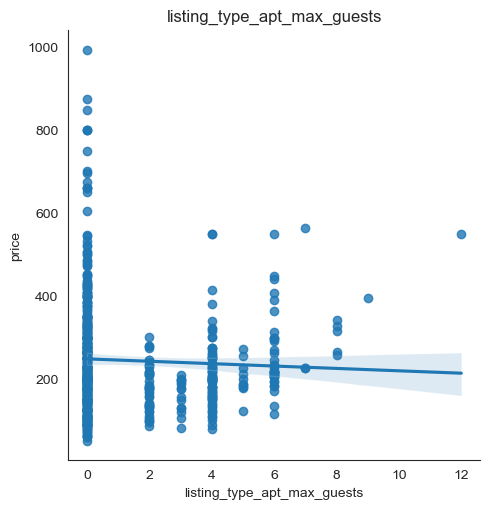

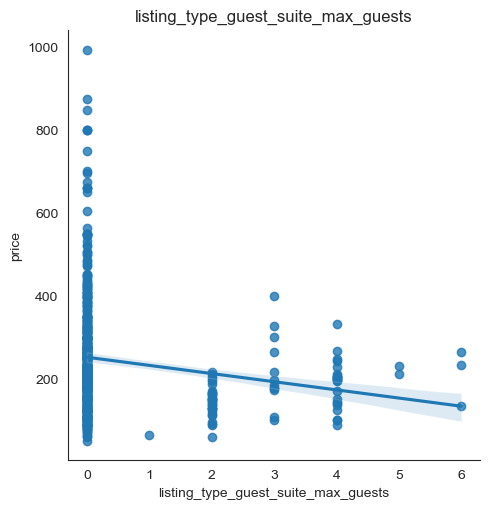

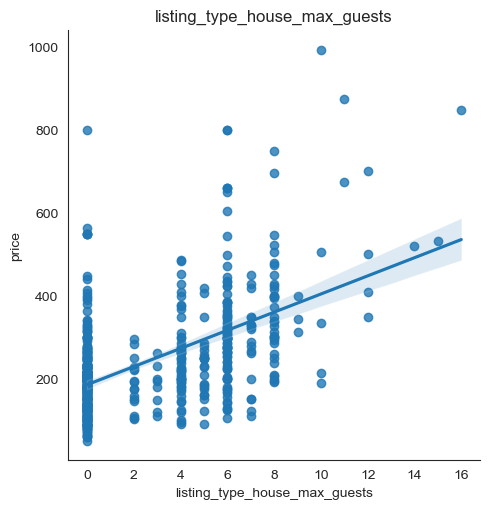

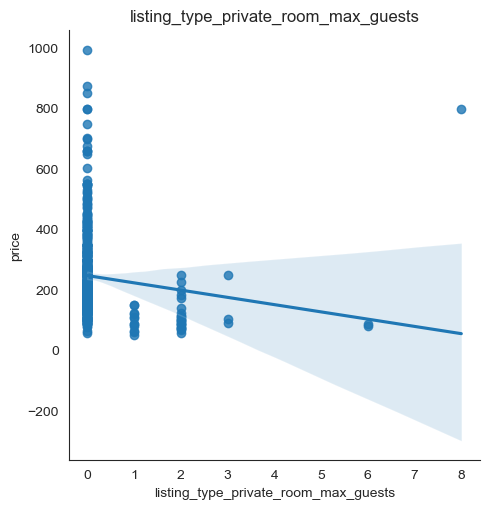

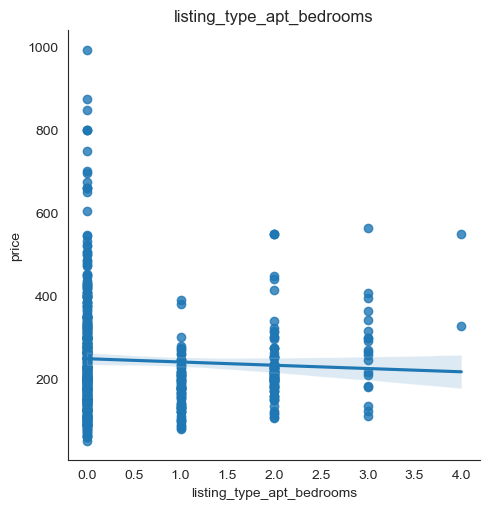

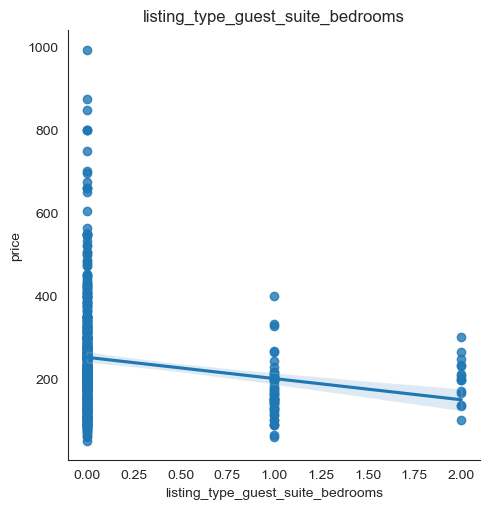

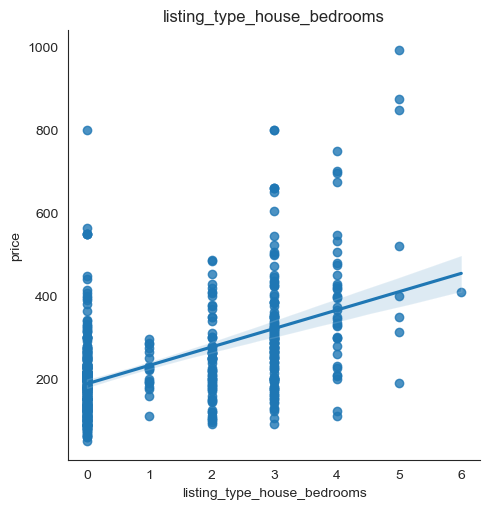

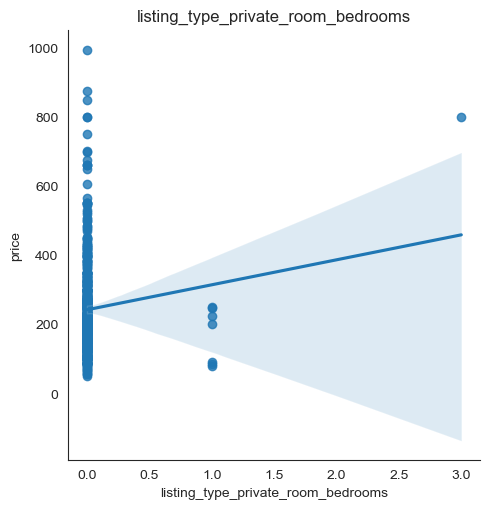

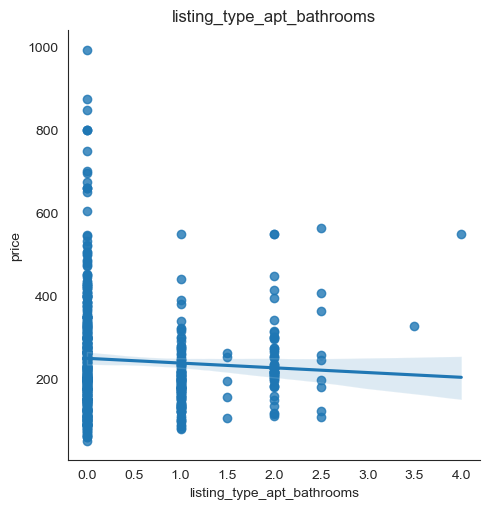

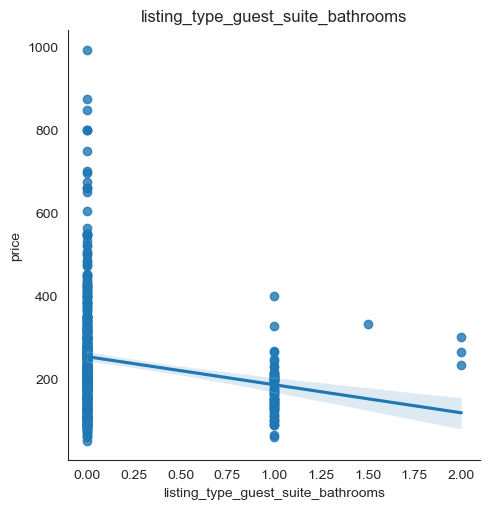

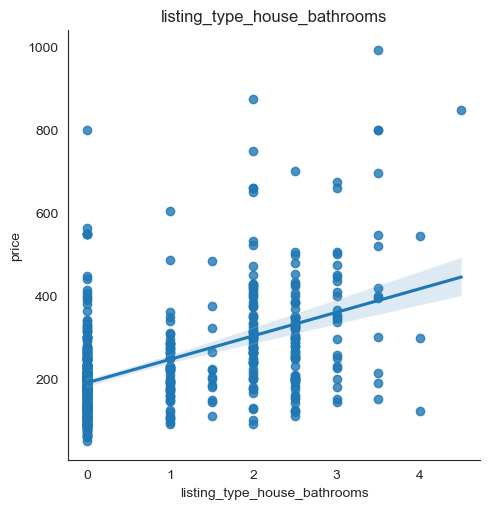

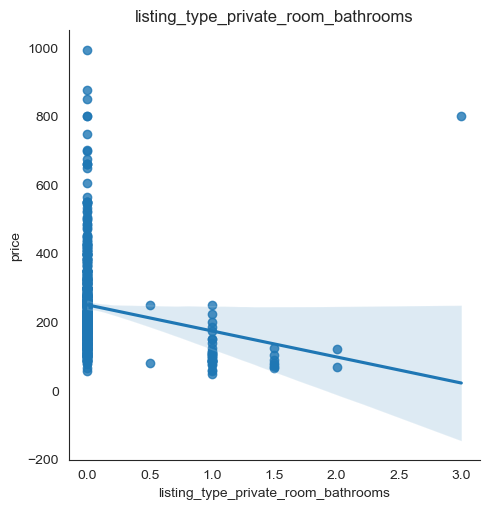

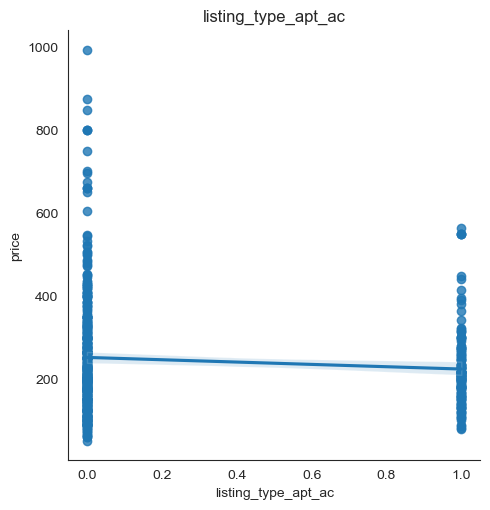

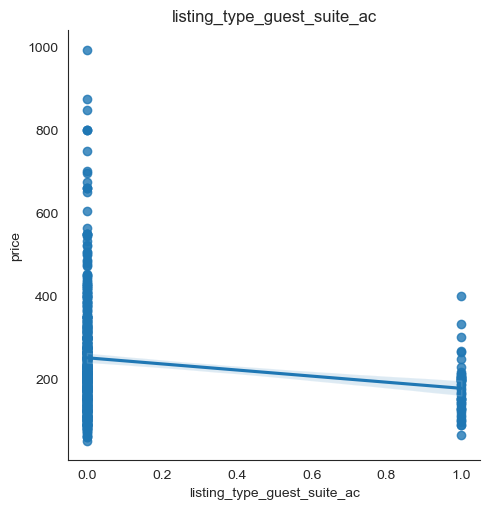

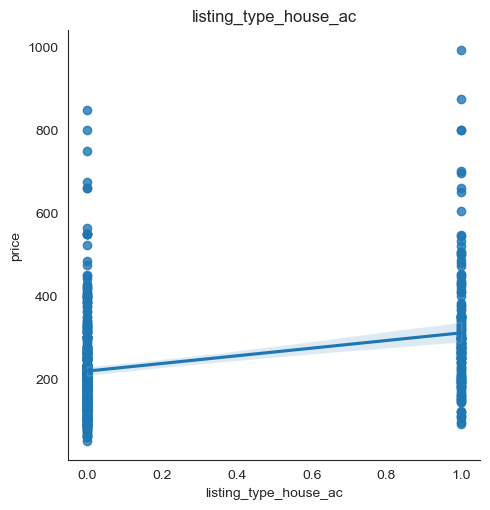

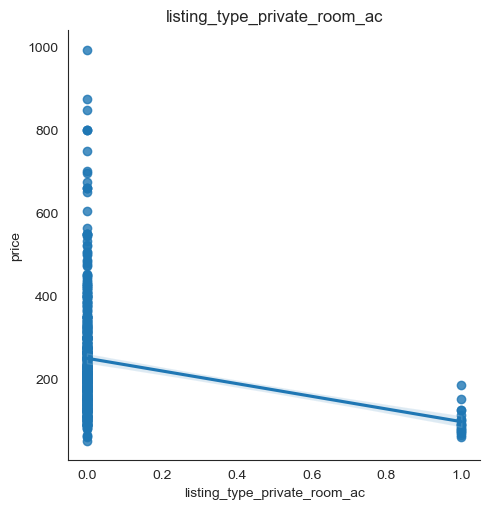

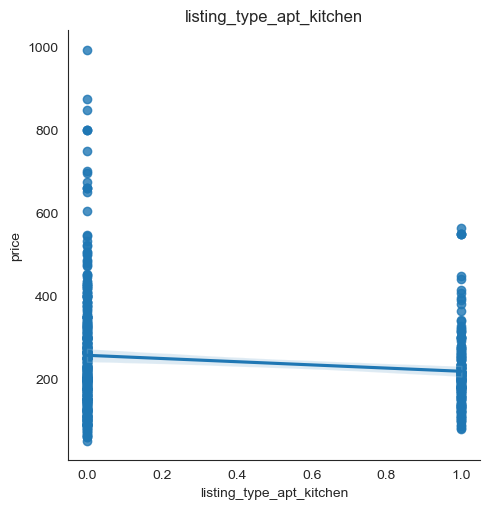

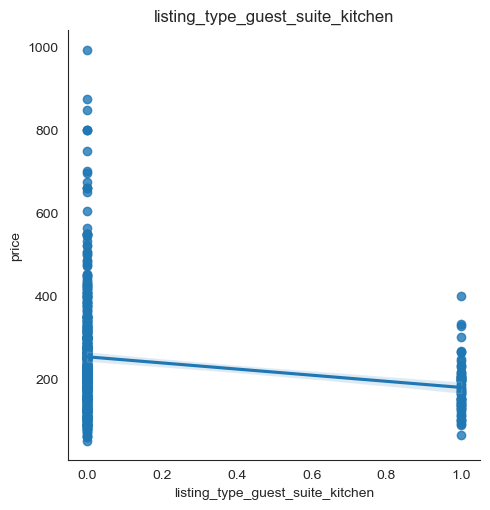

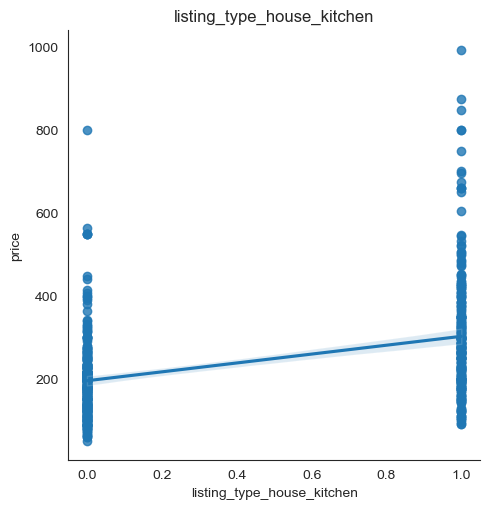

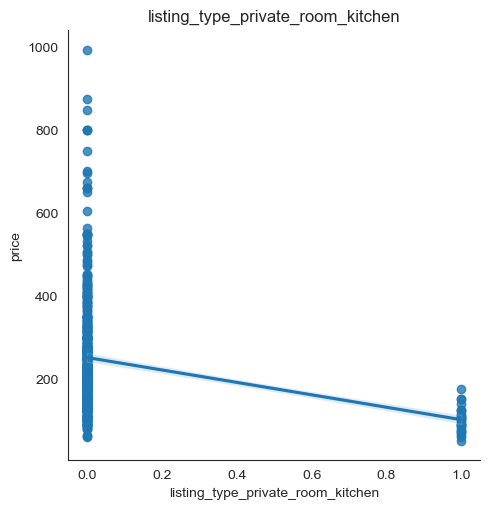

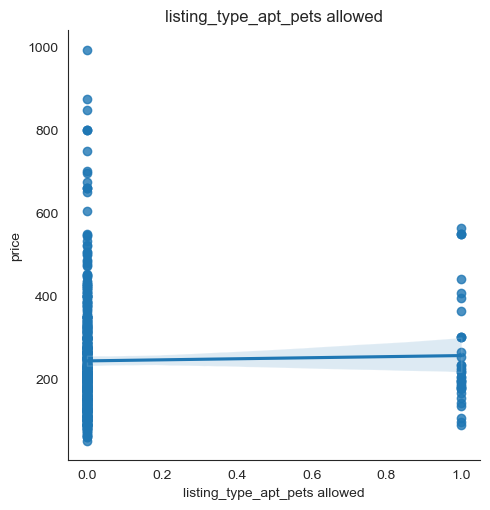

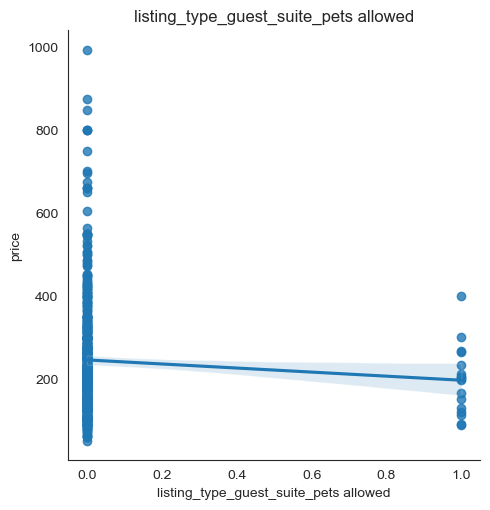

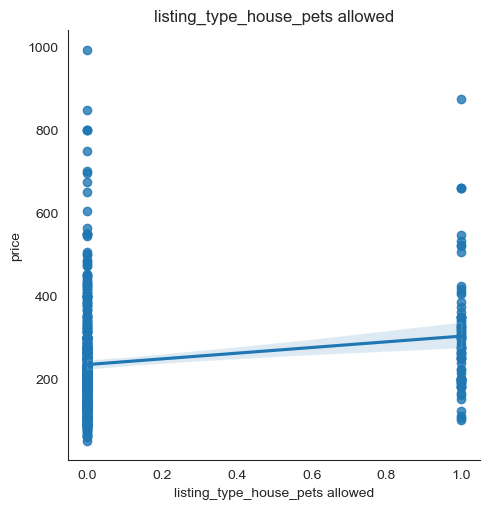

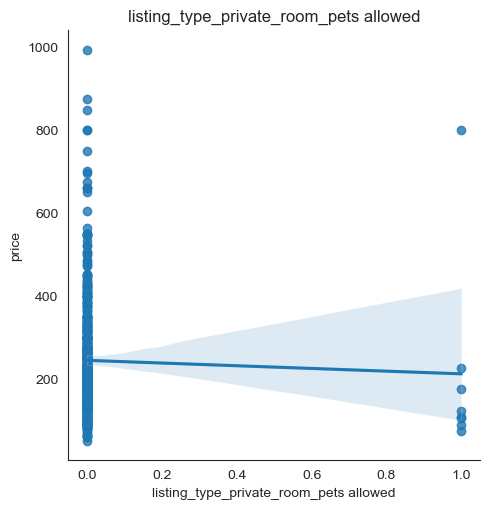

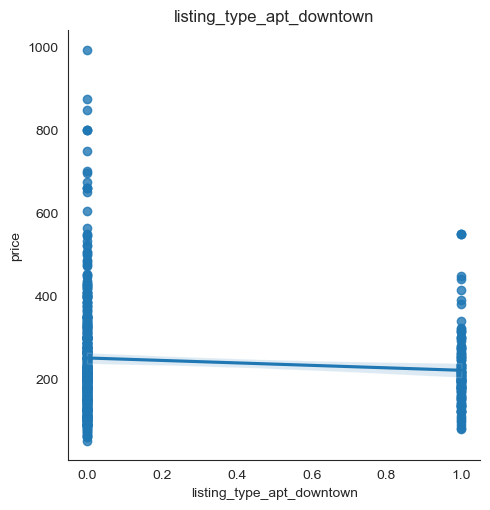

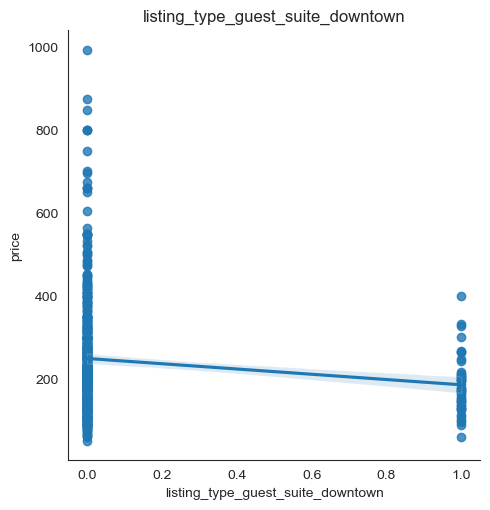

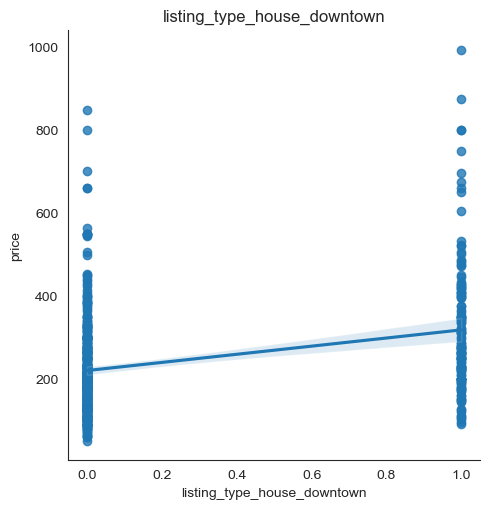

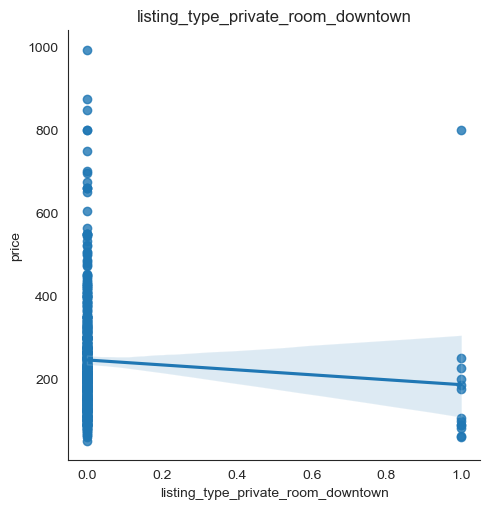

In [34]:
# Interact key features with listing type 
type_list    = ['listing_type_apt','listing_type_guest_suite', 'listing_type_house', 'listing_type_private_room']
feature_list = ['max_guests', 'bedrooms', 'bathrooms', 'ac', 'kitchen', 'pets allowed', 'downtown']

for f in feature_list:
    for m in type_list:
        listings['{}_{}'.format(m,f)] = listings[m]*listings[f]
        sns.lmplot(x='{}_{}'.format(m,f), y='price', data=listings)
        plt.title('{}_{}'.format(m,f))
        plt.plot()

In [35]:
assert False

AssertionError: 

### 5. Finalize exploratory base table


In [ ]:
# Drop columns we no longer need
listings.drop(listings[['price_str', 'bathrooms_text', 'bedrooms_str', 'property_type', 'room_type', 'amenities', 
                         'minimum_nights', 'accommodates']], axis=1, inplace=True)


In [ ]:
# Fill and flag any remaining missing values
listings.isna().sum()

# Fill NA reviews with 0 & create a flag denoting no reviews
listings[listings['review_scores_rating'].isna()].number_of_reviews.max()
listings['no_reviews_flag'] = (listings.review_scores_rating.isna()).astype(int)
listings.review_scores_rating.fillna(0, inplace=True) 

# Assert no missing values remain
assert all(listings.isna().sum()) == 0

In [ ]:
listings.to_csv('Data/expl_bt.csv', index=True)

## Exploratory Analysis

In [ ]:
listings.describe(include='all').transpose()

In [ ]:
# Plot correlations between numeric variables
correlations = listings.corr(numeric_only=True)
masks = np.zeros_like(correlations)
masks[np.triu_indices_from(masks)] = 1

plt.figure(figsize=(20,25))
sns.heatmap(correlations*100, cmap='RdBu',mask=masks, annot=True, fmt='.0f', cbar=False)

In [ ]:
# Look at relationship between ratings and price, keeping in mind new hosts wouldn't have reviews or ratings yet
type_list    = ['listing_type_apt','listing_type_guest_suite', 'listing_type_house', 'listing_type_private_room']
feature_list = ['review_scores_rating']

for f in feature_list:
    for m in type_list:
        listings['{}_{}'.format(m,f)] = listings[m]*listings[f]
        sns.lmplot(x='{}_{}'.format(m,f), y='price', data=listings, fit_reg=False)
        plt.title('{}_{}'.format(m,f))
        plt.xlim(4.5,5)
        plt.ylabel('Price')
        plt.plot()

In [ ]:
# Save labelled host # of listings for easy plotting
listings['three_cat']= listings['three_plus_listings'].astype(str)
listings.loc[listings.three_cat =='0', 'three_cat'] = '1-2 listings'
listings.loc[listings.three_cat == '1', 'three_cat'] = '3+ listings'

In [ ]:
# Create geo-dataframes of Bozeman + Airbnb locations
city = gpd.read_file('Data/City_Limits/City_Limits.shp')
city_locs = gpd.GeoDataFrame(city)
city_locs = city_locs.to_crs(epsg=4326)
city_locs.head()

airbnb_locs = gpd.GeoDataFrame(listings, 
                               geometry=gpd.points_from_xy(listings.longitude, listings.latitude)) 


#### There are more listings concentrated downtown, but the types of listings are distributed across the city:

In [ ]:
#Plot Airbnb locations on map of Bozeman, color by type

#Initalize shared axis
fig, ax = plt.subplots(figsize =(12,12))
ax.axis('off')
ax.set_title('Locations and Listings Types of Airbnbs in Bozeman, MT')

#Plot map on axis
city_locs.plot(ax=ax, color='thistle', alpha=0.5)

#Plot locations of Airbnbs
airbnb_locs.plot(column=airbnb_locs.listing_type, ax=ax, cmap='tab20', alpha =0.8, legend=True)

plt.show()

#### Most listings are relvatively inexpensive, but listings in the city center are more expensive on average:

In [ ]:
#Plot Airbnb locations on map of Bozeman, color by price

#Initalize shared axis
fig, ax = plt.subplots(figsize =(20,8))
ax.axis('off')
ax.set_title('Locations and Prices of Airbnbs in Bozeman, MT')

#Plot map on axis
city_locs.plot(ax=ax, color='thistle', alpha=0.5)

#Plot locations of Airbnbs
airbnb_locs.plot(column=airbnb_locs.price, ax=ax, cmap='rocket_r', alpha =.6, legend=True)

plt.show()

#### There are a surprising number of listings hosted by hosts with 3+ listings in Bozeman

In [ ]:
#Plot Airbnb locations on map of Bozeman, color by host having 3+ listings or not

#Initalize shared axis
fig, ax = plt.subplots(figsize =(12,12))
ax.axis('off')
ax.set_title('Locations of Airbnbs in Bozeman, MT, by host\'s # of listings')

#Plot map on axis
city_locs.plot(ax=ax, color='thistle', alpha=0.5)

#Plot locations of Airbnbs
airbnb_locs.plot(column=airbnb_locs.three_cat, ax=ax, cmap='tab20', alpha =.8, legend=True)

plt.show()

In [ ]:
# Plot distributions of features
#listings.hist(xrot=-45, figsize=(14,14))
#plt.show()

In [ ]:
# Look at object features
sns.countplot(listings.listing_type)
plt.show()

In [ ]:
listings.columns

In [ ]:
# Print out correlations with price
correlations = listings.corr(numeric_only=True)['price']
correlations.sort_values(ascending=False)

In [ ]:
# Save features that will go into the model
abt = listings[['bedrooms', 'beds', 'price', 'log_price', 'instant_bookable','bathrooms','wifi', 
                    'hot tub', 'kitchen', 'tv', 'coffee', 'washer', 'dryer', 'backyard', 
                    'pets allowed', 'workspace', 'pool', 'fire pit', 'bbq', 'ac', 
                    'free parking', 'dishwasher', 'gym', 'self check-in', 'stove', 'view', 'patio', 
                    'crib', 'total_amenities', 'rho', 'theta', 'downtown', 'long_stays_only', 
                    'max_guests', 'bedroom_and_bath', 'baths_per_bedroom', 'max_guests_sq', 
                    'bathrooms_sq', 'beds_sq', 'bedrooms_sq','bedroom_and_bath_sq', 'baths_per_bedroom_sq',
                    'listing_type_apt_max_guests', 'listing_type_guest_suite_max_guests',
                   'listing_type_house_max_guests', 'listing_type_private_room_max_guests',
                    'listing_type_apt', 'listing_type_guest_suite', 'listing_type_house', 'listing_type_private_room', 
                    'listing_type_apt_bedrooms', 'listing_type_guest_suite_bedrooms', 
                    'listing_type_house_bedrooms', 'listing_type_private_room_bedrooms',
                   'listing_type_apt_bathrooms', 'listing_type_guest_suite_bathrooms',
                   'listing_type_house_bathrooms', 'listing_type_private_room_bathrooms',
                   'listing_type_apt_ac', 'listing_type_guest_suite_ac', 'listing_type_house_ac', 'listing_type_private_room_ac',
                   'listing_type_apt_kitchen', 'listing_type_guest_suite_kitchen','listing_type_house_kitchen', 
                   'listing_type_private_room_kitchen','listing_type_apt_pets allowed','listing_type_guest_suite_pets allowed',
                   'listing_type_house_pets allowed','listing_type_private_room_pets allowed', 'listing_type_apt_downtown',
                   'listing_type_guest_suite_downtown', 'listing_type_house_downtown', 'max_guests_sq', 'max_guests_cu', 'bathrooms_sq',
                   'bathrooms_cu', 'beds_sq', 'beds_cu', 'bedrooms_sq', 'bedrooms_cu',
                   'bedroom_and_bath_sq', 'bedroom_and_bath_cu', 'baths_per_bedroom_sq',
                   'baths_per_bedroom_cu', 'listing_type_private_room_downtown']].copy()
# 'listing_type',

In [ ]:
# Assert no missing values remain
assert all(listings.isna().sum()) == 0

In [ ]:
# Assert all features are numeric
assert all(abt.dtypes.map(pd.api.types.is_numeric_dtype)) == True

In [ ]:
# Save data
abt.to_csv('Data/abt.csv', index=None)

## Algorithm Selection

Split data into train and test sets. Set up pipelines for regularized regression (parametric) and tree ensemble algorithms (non-parametric). Initialize hyperparameter grids, which will enable algorithms to perform embedded feature selection. 

In [ ]:
#Load abt
abt = pd.read_csv('Data/abt.csv')

In [ ]:
#Split data into taining and test sets
y = abt.log_price
X = abt.drop(columns=['price', 'log_price'], axis=1)

s = 987
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=s) 

In [ ]:
type_list    = ['listing_type_apt','listing_type_guest_suite', 'listing_type_house', 'listing_type_private_room']
for m in type_list:
    print(m)
    print('Train:', X_train[m].mean())
    print('Test:', X_test[m].mean())

In [ ]:
# Create pipelines dictionary
pipelines = {
    # Regularized regression algorithms
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state = s)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state = s)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state=s)),
    # Tree ensemble algorithms
    'rf'    : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=s)),
    'gb'    : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=s)),
    'xgb'   : make_pipeline(StandardScaler(), XGBRegressor(random_state=s))
}

# Declare hyperparameters to tune
lasso_hp = {
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}
ridge_hp = {
    'ridge__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}
enet_hp = {
    'elasticnet__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]
}
rf_hp = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_features': [1, 'sqrt', 0.33]
}
gb_hp = {
    'gradientboostingregressor__n_estimators' : [100, 200],
    'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}   
xgb_hp = {
    'xgbregressor__n_estimators' : [100, 200],
    'xgbregressor__learning_rate': [0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [1, 3, 5]
}   

# Compile hyperparameter grids into single dictionary
hyperparameters = {
    'lasso' : lasso_hp,
    'ridge' : ridge_hp,
    'enet'  : enet_hp,
    'rf'    : rf_hp,
    'gb'    : gb_hp,
    'xgb'   : xgb_hp
}

In [ ]:
# Print dictionary
print(hyperparameters)

In [ ]:
# Check that hyperparameter grid was created correctly
for key in ['lasso', 'ridge', 'enet', 'rf', 'gb', 'xgb']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
            print( key, 'was not found in hyperparameters')

## Model Training

Tune hyperparameters and calculate performance metrics. Pick a best model.

In [ ]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Define model
    model = GridSearchCV(pipeline, hyperparameters[name], cv= 10, n_jobs = -1)

    # Fit model
    model.fit(X_train, y_train)

    # Store model in dictionary
    fitted_models[name] = model

    # Print
    print(name, 'has been fitted')

In [ ]:
# Check that models were sucessfully fitted
for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

In [ ]:
# Display performance metrics for each model
for key, model in fitted_models.items():
    pred = model.predict(X_test)
    print(key)
    print('----') 
    print('R^2:', r2_score(y_test,pred))
    print('MAE:', mean_absolute_error(10**y_test,10**pred))
    print()

In [ ]:
best = 'ridge'

In [ ]:
# Plot performance of winning model
pred = fitted_models[best].predict(X_test)
plt.scatter(10**pred, 10**y_test)
plt.plot( [0,1000], [0,1000], linestyle='--', color='k' )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.axis('square')
#plt.ylim(0,1000)
#plt.xlim(0,1000)
plt.show()

In [ ]:
# Display best pipeline - hyperparameter values
fitted_models[best].best_estimator_

In [ ]:
# Save best pipeline object
with open('final_model.pkl','wb') as f:
    pickle.dump(fitted_models[best].best_estimator_, f)

## Insights & Analysis

Results: The ridge regression eeked out the best performance with a mean absolute error of $53 and an R^2 suggesting the model was able to capture 71% of the variation in the data. Not too shabby! This model would probably perform even better in a larger city setting where neighborhoods and proximity to desirable locations vary more than they do in Bozeman. This project taught me a lot about the importance of domain knowledge and feature engineering. While there was a lot of useful raw information available, it took extensive manipulation, data exploration, and calling on my own experiences as an Airbnb guest and host to creatively engineer features that the algorithms would be able to use to predict listing prices. 

If I were to continue working on this, I would love to build something that takes into account other aspects that impact price that would take a bit more work to include. These include seasonality, which could be added to the model using time-series data, cosmetic appeal, which could be brought into the model through image analysis of listing thumbnails, information only provided in the text of a listing (caveats, special notes, rules, etc), which could be brought into the model using NLP, and host preferences (such as a host preferring maximum booked nights (thus willing to drop the price to fill empty days) versus a host who would rather see the listing sit empty than accept an amount less than X due to cleaning or hassle costs), which could be brought into the model through the classification of hosts into types using time-series data.

Theoretical next steps for the implementation of this tool would be to: 
1. Create a generalized version to predict price in any market. \
    I wanted to do a deep dive on Bozeman's Airbnb market that would allow me to understand the kinds of listings that are most common, where listings are located, minimum stays, popular amenities, and what kinds of hosts have listings in Bozeman in connection with another project. Generalizing this tool this would include removing Bozeman-specific data cleaning steps and making them flexible to other markets. For example, neighborhood classifiers would undoubtedly be useful in larger cities - Bozeman's data only had 1 neighborhood - and shared rooms are likely more prevalent in other markets, so could be included - Bozeman only had one shared room listing in this data. To scale this script, I would add more assert checks and more flexible conditional statements to account for differences in the data available in different markets. 
2. Build a user-friendly interface that takes in X key characteristics about a new listing and uses the winning model to suggest a listing price.